In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import geopandas as gpd
import matplotlib as mpl
import requests
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pandas.api.types import is_numeric_dtype
import os

from pkg import regress, plot_map, clean_map_gpd, detrend_group

os.chdir("/Users/caropark/FAO_ag_check_code/")
plt.rcParams.update({'font.size': 22})

## Input data, clean to match country ID, run regression

In [2]:
combined = pd.read_csv("./data/yield_comparison.csv")

In [3]:
## run regression of yield against csif for each iso_a3/crop
regs = combined.groupby(['iso_a3', 'cropname']).apply(regress, 'yield_log_dt', ['csif_log_dt'])
regs.columns=["sif_coefficient", "r2", "resid_var"]
regs = regs.reset_index().dropna()
regs = regs.query('r2 < 1 ')
regs.replace([np.inf, -np.inf], np.nan, inplace=True)
regs["sif_coefficient"] = np.sign(regs["sif_coefficient"])

## determine the majority sign of the SIF coefficient for each iso_a3, and average R2
sif_sign = (regs.groupby("iso_a3")["sif_coefficient"].agg(pd.Series.mode).reset_index()
    .explode("sif_coefficient")
    .groupby("iso_a3")
    .mean().reset_index()
    .assign(pos_neg=lambda d: np.where(d["sif_coefficient"] < 1, "neg", "pos")))
avg_r2 = regs.groupby('iso_a3')['r2'].mean().reset_index()
regs_avg = sif_sign.merge(avg_r2)
regs_best = regs.loc[regs.groupby('iso_a3')["r2"].idxmax()]

## gdp data
gdp_df = pd.read_csv("./data/wb_gdp_per_cap.csv")

# ## lead/lag analysis
leadlag = (pd.DataFrame(combined[["cropname", "iso_a3", "whichlag"]].drop_duplicates().reset_index(drop=True)
                  .groupby('iso_a3')['whichlag'].value_counts(normalize=True).round(2))
                  .rename(columns={'whichlag':'pct'}).reset_index().drop_duplicates())

leadlag_majority = leadlag.groupby('iso_a3')['pct'].idxmax()
leadlag_cat = leadlag.loc[leadlag_majority.dropna()]

leadlag_pct = leadlag.copy()
leadlag_pct['whichlag'] = leadlag_pct['whichlag'].replace({'yield_lag': 'lead/lag', 'yield_lead': 'lead/lag'})
leadlag_pct = leadlag_pct.groupby(['iso_a3', 'whichlag']).sum('pct').reset_index()
leadlag_pct = leadlag_pct[leadlag_pct['whichlag']=="lead/lag"]
leadlag_pct['pct'] = 1-leadlag_pct['pct']

# fao flag analysis
fao = (pd.read_csv("./data/faostat_all_flags.csv")[lambda df: df['Flag Description'] == "Estimated value"]
       .query("cropname == 'Maize' "))
fao['flag'] = pd.to_numeric(1)
fao = fao.groupby('iso_a3').sum('flag')['flag'].reset_index()


In [4]:
combined['whichlag'].value_counts(normalize=True)

yield_log_dt    0.444646
yield_lead      0.302130
yield_lag       0.253224
Name: whichlag, dtype: float64

## Plots

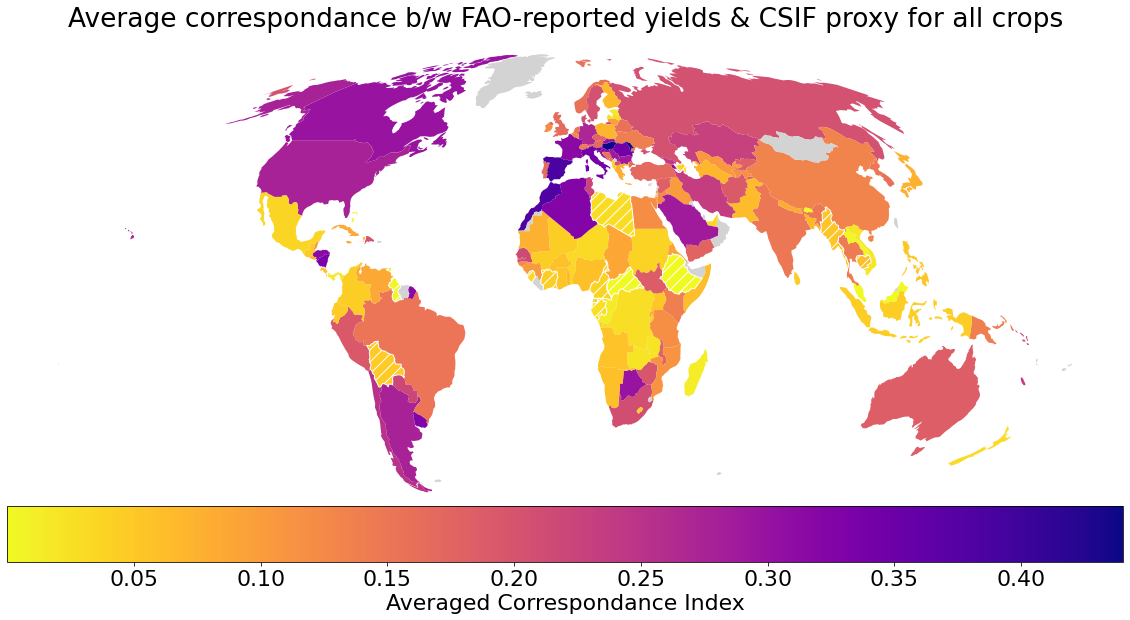

In [5]:
plot_map(regs_avg, column="r2", 
         title="Average correspondance b/w FAO-reported yields & CSIF proxy for all crops", 
         cbar_label="Averaged Correspondance Index", cmap="plasma_r", 
         filename="avg_corr_map")

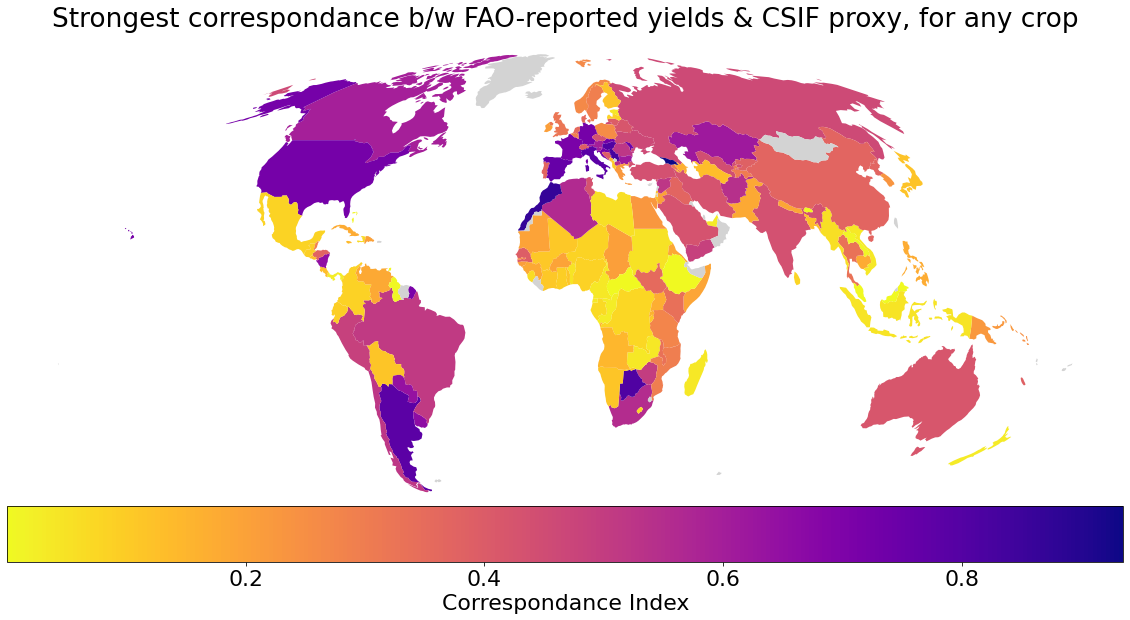

In [6]:
plot_map(regs_best, column="r2", 
         title="Strongest correspondance b/w FAO-reported yields & CSIF proxy, for any crop", 
         cmap="plasma_r", cbar_label="Correspondance Index",
         filename="best_corr_map")

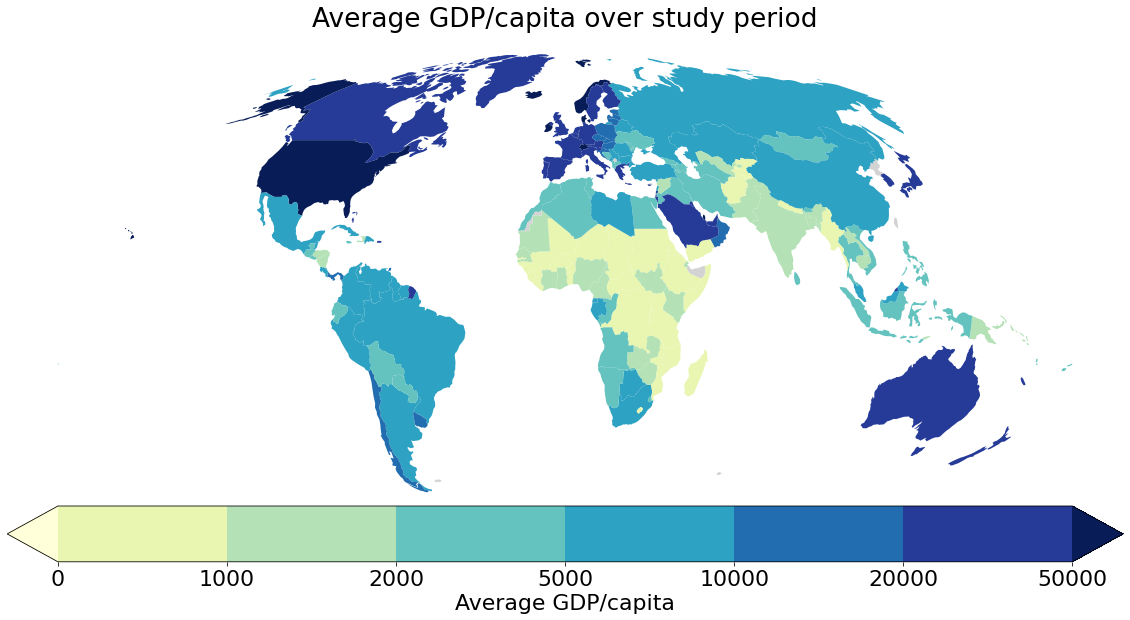

In [7]:
bounds = [0, 1000, 2000, 5000, 10000, 20000, 50000]
cmap = plt.cm.YlGnBu
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

plot_map(gdp_df, column="value", 
         title="Average GDP/capita over study period", 
         cmap="YlGnBu", cbar_label="Average GDP/capita", norm=norm,
         filename="avg_gdp_map")

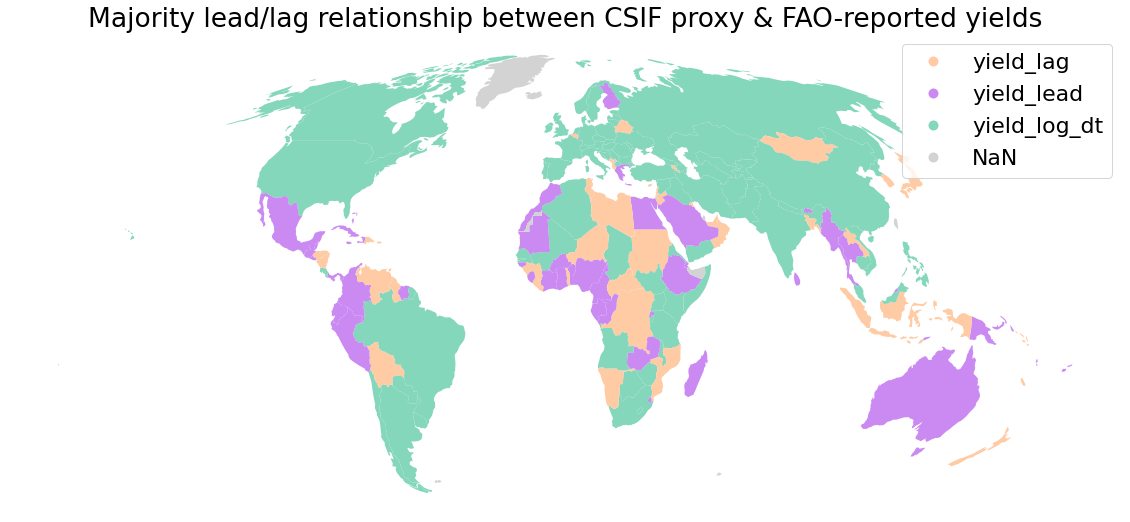

In [8]:
colors = ["#ffcba4", "#ca8af2", "#84d7bb"]
newcmp = ListedColormap(colors)

plot_map(leadlag_cat, column="whichlag", 
         title="Majority lead/lag relationship between CSIF proxy & FAO-reported yields", 
         cmap=newcmp, cbar_label=None,
         filename="leadlag_map")

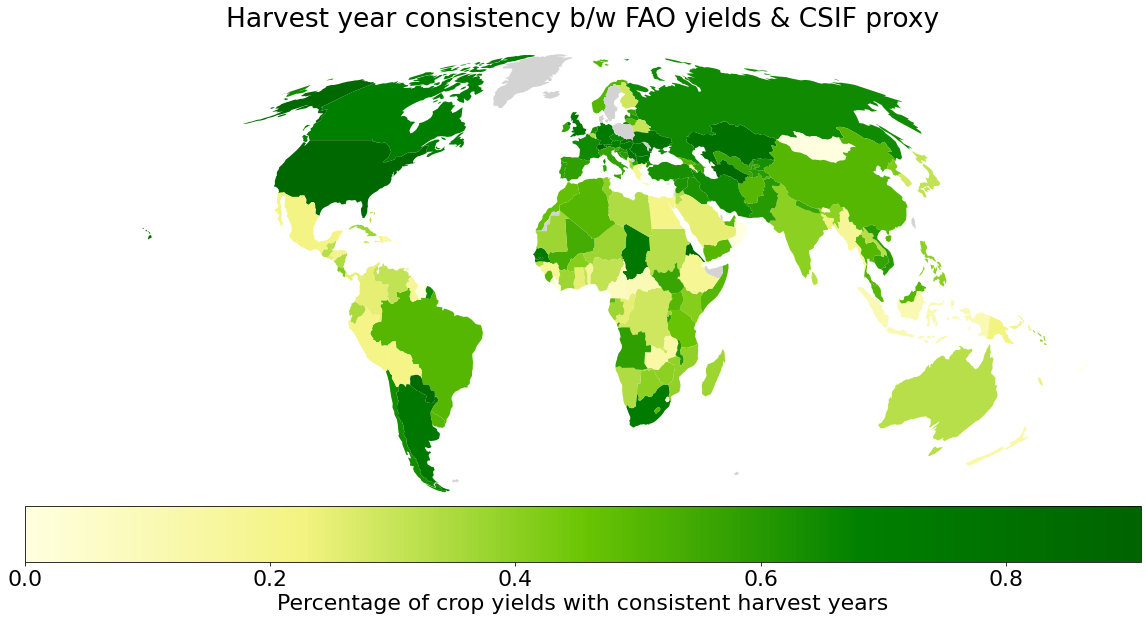

In [9]:
colors = ["lightyellow", "#f3f380", "#6bc504", "green", "darkgreen"]
new_cmap = mcolors.LinearSegmentedColormap.from_list("YellowToGreen", colors)

plot_map(leadlag_pct, column="pct", 
         title="Harvest year consistency b/w FAO yields & CSIF proxy", 
         cmap=new_cmap, cbar_label="Percentage of crop yields with consistent harvest years",
         filename="leadlag_pct_map")


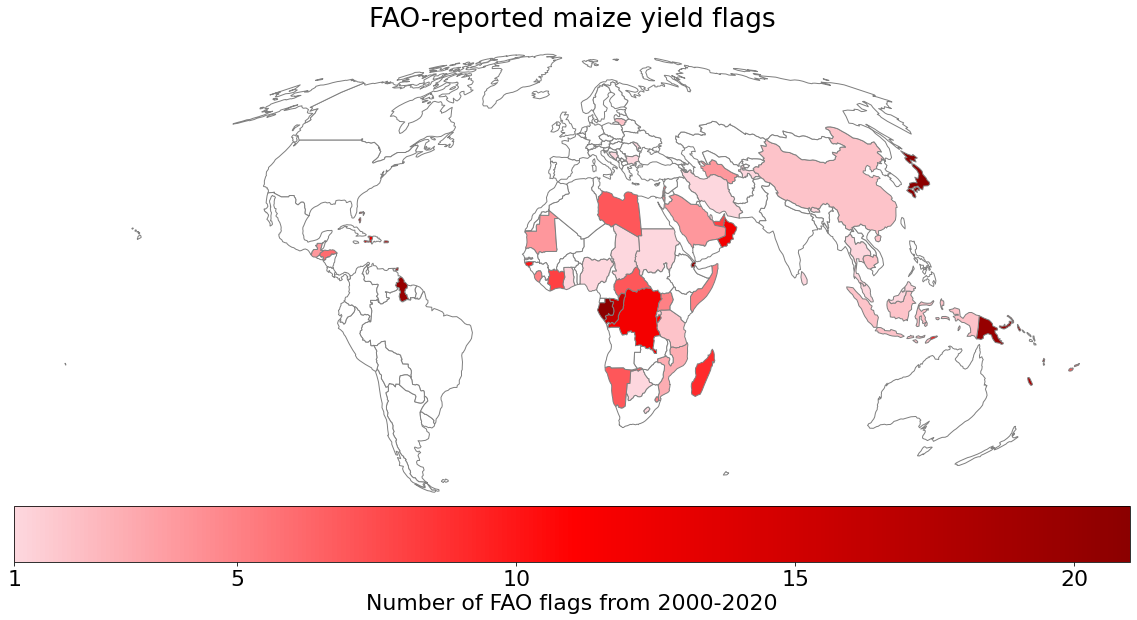

In [10]:
colors = ["#fdd7de", "red", "darkred"]
custom_cmap = LinearSegmentedColormap.from_list("pink_to_darkred", colors)

plot_map(fao, column="flag", title="FAO-reported maize yield flags", cmap=custom_cmap, 
         cbar_label= None, 
         edgecolor="gray", vmin=1,
         legend_kwds= {'label': "Number of FAO flags from 2000-2020",
                        'ticks': [1, 5, 10, 15, 20], "orientation": "horizontal", 'pad':-0.01},
         missing_kwds={'color': 'white'},
         filename="fao_flags_map")
